Try to read and make the best from the dataset

**Agrupación episodios por paciente**

**Transformaciones a los episodios: codificación diagnosticos acorde con POA, filtrado y agrupación de diagnosticos y tratamientos segun presencia (no podemos cojer todos para el OHE)**

In [ ]:


import pandas as pd

# Cargando los datos desde el archivo CSV proporcionado
file_path = 'scrambled-CMBDAH 2021-23 episodes.csv'
df = pd.read_csv(file_path, sep=';', low_memory=False)  # Usando low_memory=False para evitar problemas de tipos de datos

# Limpiando y convirtiendo la columna 'Data_naix' a tipo fecha sin la hora para asegurar consistencia
df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date  # Asegurando el formato correcto de fecha

# Agrupando los datos por 'Data_naix' y 'Sexe' y asignando el 'Id_pacient' del primer episodio encontrado en cada grupo
df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')

# Guardando el DataFrame modificado en un archivo CSV nuevo
output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
df.to_csv(output_path_modified,  sep=';', index=False)

# Imprimir la ruta del archivo guardado para que el usuario sepa dónde encontrarlo
print("DataFrame completo con IDs modificados guardado en:", output_path_modified)


from sklearn.preprocessing import MultiLabelBinarizer

# Cargar datos
df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')

#Definir frecuencia significativa
frecuence = 0.0005

# Modificar DP y DSx para incluir indicadores POA
df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)

# Modificar todos los diagnósticos secundarios (DSx)
for i in range(1, 15):
    df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

# Agrupar todos los diagnósticos secundarios en una lista
df['other_diagnostics'] = df[['DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14']].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

# Agrupar por 'Id_pacient', consolidando diagnósticos
df_grouped_diagnostics = df.groupby('Id_pacient').agg({
    'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,  # Tomar el DP más frecuente o el primer valor si hay empate
    'other_diagnostics': lambda x: [item for sublist in x for item in sublist]  # Unir todos los diagnósticos secundarios
}).reset_index()

# Juntar DP y diagnósticos secundarios para hacer el análisis de frecuencia
all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()

# Contar frecuencia de diagnósticos
diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
significant_diagnostics = diagnostic_counts[diagnostic_counts > frecuence].index  # Mantener solo los diagnósticos más frecuentes (>1%)

# Filtrar DP y otros diagnósticos significativos
df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])

# Si no hay diagnósticos significativos, agregar un diagnóstico vacío para evitar filas vacías en el OHE
df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

# Repetir el mismo proceso para tratamientos
df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)

# Agrupar todos los tratamientos secundarios (PSx)
df['other_treatments'] = df[['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14']].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

# Agrupar por 'Id_pacient', consolidando tratamientos
df_grouped_treatments = df.groupby('Id_pacient').agg({
    'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,  # Tomar el tratamiento principal más frecuente o el primer valor si hay empate
    'other_treatments': lambda x: [item for sublist in x for item in sublist]  # Unir todos los tratamientos secundarios
}).reset_index()

# Juntar PP y tratamientos secundarios para hacer el análisis de frecuencia
all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()

# Contar frecuencia de tratamientos
treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
significant_treatments = treatment_counts[treatment_counts > frecuence].index  # Mantener solo los tratamientos más frecuentes (>1%)

# Filtrar PP y otros tratamientos significativos
df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])

# Si no hay tratamientos significativos, agregar un tratamiento vacío para evitar filas vacías en el OHE
df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

# Aplicar One-Hot Encoding para diagnósticos y tratamientos
mlb_diagnostics = MultiLabelBinarizer()
diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

mlb_treatments = MultiLabelBinarizer()
treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

# Concatenar los resultados de diagnósticos y tratamientos
df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)

# Guardar el resultado en un archivo CSV
output_path = 'final_ohe_patients.csv'
df_combined.to_csv(output_path, sep=';', index=False)
print(f"Resultado guardado en {output_path}")
print(df_combined.shape)


# Extraer las columnas correspondientes a diagnósticos y tratamientos codificados
diagnostics_encoded = diagnostics_df.values  # Convertir a array de numpy
treatments_encoded = treatments_df.values    # Convertir a array de numpy

# Concatenar las matrices horizontales (One-Hot Encodings)
X = np.hstack((diagnostics_encoded, treatments_encoded))

# Mostrar una muestra del resultado
print(X[:5])

# Verificar las dimensiones de X
print(f"Dimensiones de X: {X.shape}")

import CoreFunctions as cf

k = 20           #k is the number of clusters

#Run the proposed clustering algorithm 

#### Nomes estic fent el clustering amb els diagnostics, hauria de contemplar totes les altres variables? No
M,P,CL = cf.NaiveBayesClustering(X,k)

df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')

# Asegúrate de que la longitud del array de clusters coincide con el número de filas en df_combined
if len(CL) == len(df_combined):
    df_combined['cluster'] = CL
else:
    raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

# Ahora, une 'df_grouped' que contiene los clusters con el DataFrame original 'df' usando 'Id_pacient'
# Unimos la información de cluster al DataFrame original 'df' usando 'Id_pacient'
df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
df_cluster.to_csv('data_cluster.csv', sep=';', index=False)

df_cluster.head()
print(df_cluster.shape)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import CoreFunctions as cf  # Suponiendo que tienes este módulo disponible
import os

# Cargar los datos
file_path = 'scrambled-CMBDAH 2021-23 episodes.csv'
df = pd.read_csv(file_path, sep=';', low_memory=False)

# Limpiar y convertir la columna 'Data_naix' a tipo fecha
df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date

# Agrupar los datos por 'Data_naix' y 'Sexe' y asignar el 'Id_pacient'
df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')

# Guardar DataFrame modificado
output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
df.to_csv(output_path_modified, sep=';', index=False)

# Cargar datos modificados
df = pd.read_csv(output_path_modified, sep=';')

# Definir frecuencia significativa
frecuence = 0.0005

# Modificar DP y DSx para incluir indicadores POA
df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)

# Modificar todos los diagnósticos secundarios (DSx)
for i in range(1, 15):
    df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

# Agrupar diagnósticos secundarios en una lista
df['other_diagnostics'] = df[[f'DS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

# Agrupar por 'Id_pacient', consolidar diagnósticos
df_grouped_diagnostics = df.groupby('Id_pacient').agg({
    'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
    'other_diagnostics': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Juntar DP y diagnósticos secundarios para análisis de frecuencia
all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()

# Contar frecuencia de diagnósticos
diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
significant_diagnostics = diagnostic_counts[diagnostic_counts > frecuence].index

# Filtrar diagnósticos significativos
df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])

# Repetir para tratamientos
df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)
df['other_treatments'] = df[[f'PS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

df_grouped_treatments = df.groupby('Id_pacient').agg({
    'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
    'other_treatments': lambda x: [item for sublist in x for item in sublist]
}).reset_index()

# Contar frecuencia de tratamientos
all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()
treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
significant_treatments = treatment_counts[treatment_counts > frecuence].index

# Filtrar tratamientos significativos
df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])

# Aplicar One-Hot Encoding para diagnósticos y tratamientos
mlb_diagnostics = MultiLabelBinarizer()
diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

mlb_treatments = MultiLabelBinarizer()
treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

# Concatenar diagnósticos y tratamientos
df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)

# Definir número de clusters a iterar
k_values = [20, 50, 100]

for k in k_values:
    # Concatenar matrices (One-Hot Encodings)
    X = np.hstack((diagnostics_encoded, treatments_encoded))

    # Ejecutar algoritmo de clustering
    M, P, CL = cf.NaiveBayesClustering(X, k)

    # Asegurar que la longitud del array de clusters coincide con el número de filas
    if len(CL) == len(df_combined):
        df_combined['cluster'] = CL
    else:
        raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

    # Unir los clusters al DataFrame original y guardar el resultado
    df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
    cluster_output_path = f'data_cluster_k{k}.csv'
    df_cluster.to_csv(cluster_output_path, sep=';', index=False)
    print(f"Clustering con k={k} guardado en {cluster_output_path}")


In [ ]:


import pandas as pd
import numpy as np
from collections import Counter

# Obtiene los clusters únicos
clusters = df_cluster['cluster'].unique()
cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)  # Normalizado para obtener la proporción

# Preparar el diccionario para almacenar las métricas por cluster
cluster_metrics = {}
import pandas as pd
import numpy as np
from collections import Counter

# Función para detectar valores faltantes (tanto NaN como vacíos)
def calculate_missing_metrics(df, columns):
    """
    Calculate the proportion of missing values in the specified columns (i.e., NaN or empty).
    """
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

# Función para obtener los diagnósticos más frecuentes con frecuencias relativas
def get_top_n_diagnoses_with_poa_suffix_v2(df, diagnosis_columns, poa_columns, n=8, separate_DP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_DP = pd.Series(dtype=int)
    missing_count_DP = 0
    missing_count_secondary = 0
    total_count_DP = 0
    total_count_secondary = 0

    # Diccionario de sufijos para los códigos POA
    poa_suffix_map = {
        'S': '-S',
        'N': '-N',
        'D': '-D',
        'I': '-I',
        'E': '-E'
    }

    # Si separamos el diagnóstico principal (DP)
    if separate_DP:
        df.loc[:, 'DP'] = df.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
        
        # Contar diagnósticos principales (DP)
        count_series_DP = df['DP'].value_counts()
        total_count_DP = len(df['DP'])
        missing_count_DP = df['DP'].isnull().sum() + (df['DP'] == '').sum()  # Contar vacíos como missing

        # Excluir DP para procesar diagnósticos secundarios
        diagnosis_columns = diagnosis_columns[1:]
        poa_columns = poa_columns[1:]

    # Combinar todos los diagnósticos secundarios
    for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
        df.loc[:, diag_col] = df.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
        
        # Contar diagnósticos secundarios
        missing_count_secondary += df[diag_col].isnull().sum() + (df[diag_col] == '').sum()  # Contar vacíos como missing
        count_series_secondary = count_series_secondary.add(df[diag_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[diag_col])

    # Convertir las cuentas en frecuencias relativas
    dp_top_n = count_series_DP.nlargest(n)
    dp_top_n_rel = dp_top_n / dp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    # Proporción de valores faltantes
    missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'DP': dp_top_n_rel.to_dict(),
        'other_diagnoses': secondary_top_n_rel.to_dict(),
        'missing_DP': missing_proportion_DP,
        'missing_secondary': calculate_missing_metrics(cluster_data, diagnosis_columns)
    }
    
    return results

# Función para obtener los tratamientos más frecuentes con frecuencias relativas
def get_top_n_treatments_with_missing_v2(df, treatment_columns, n=100, separate_PP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_PP = pd.Series(dtype=int)
    missing_count_PP = 0
    missing_count_secondary = 0
    total_count_PP = 0
    total_count_secondary = 0

    # Si separamos el tratamiento principal (PP)
    if separate_PP:
        count_series_PP = df['PP'].value_counts()
        total_count_PP = len(df['PP'])
        missing_count_PP = df['PP'].isnull().sum() + (df['PP'] == '').sum()

        # Excluir PP para procesar los tratamientos secundarios
        treatment_columns = treatment_columns[1:]

    # Combinar todos los tratamientos secundarios
    for treatment_col in treatment_columns:
        missing_count_secondary += df[treatment_col].isnull().sum() + (df[treatment_col] == '').sum()
        count_series_secondary = count_series_secondary.add(df[treatment_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[treatment_col])

    pp_top_n = count_series_PP.nlargest(n)
    pp_top_n_rel = pp_top_n / pp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'PP': pp_top_n_rel.to_dict(),
        'other_treatments': secondary_top_n_rel.to_dict(),
        'missing_PP': missing_proportion_PP,
        'missing_secondary': calculate_missing_metrics(cluster_data, treatment_columns)
    }

    return results

# Función para obtener distribución cuantílica personalizada para variables continuas
def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()

    if col_range > 400:
        num_bins = 1000  # Ajustar el número de bins para valores amplios
    
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()

    return binned_distribution

# Bucle principal para calcular las métricas por cluster
for cluster in clusters:
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    
    metrics = {'frecuencia_cluster': cluster_frequencies[cluster]}

    # Cálculo de proporciones de missing para tratamientos secundarios y diagnósticos secundarios
    diagnosis_columns = ['DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14']
    treatment_columns = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14']
    
    # metrics['missing_secondary_treatments'] = calculate_missing_metrics(cluster_data, treatment_columns)
    # metrics['missing_secondary_diagnoses'] = calculate_missing_metrics(cluster_data, diagnosis_columns)

    categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
    continuous_vars = ['Edat', 'Dies_estada', 'DRG']

    episode_counts = cluster_data['Id_pacient'].value_counts()
    metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()

    # Calcular frecuencias relativas para las variables categóricas
    for var in categorical_vars:
        metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()

        # Calcular distribución cuantílica para las variables continuas
    for var in continuous_vars:
        metrics[var] = get_custom_binned_distribution(cluster_data, var)

    # Diagnósticos más frecuentes y valores faltantes
    metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
        cluster_data, 
        ['DP', 'DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14'],
        ['POAP', 'POA1', 'POA2', 'POA3', 'POA4', 'POA5', 'POA6', 'POA7', 'POA8', 'POA9', 'POA10', 'POA11', 'POA12', 'POA13', 'POA14'],
        n=200, separate_DP=True
    )

    # Tratamientos más frecuentes y valores faltantes
    metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
        cluster_data, 
        ['PP', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14'],
        n=200, separate_PP=True
    )



    cluster_metrics[cluster] = metrics

# Mostrar resultados en el orden solicitado
for cluster, data in cluster_metrics.items():
    print(f"Cluster {cluster}:")
    for key, value in data.items():
        print(f"  {key}: {value}")
    print("\n")

Con bucle

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

# Función para detectar valores faltantes (tanto NaN como vacíos)
def calculate_missing_metrics(df, columns):
    """
    Calculate the proportion of missing values in the specified columns (i.e., NaN or empty).
    """
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

# Función para obtener los diagnósticos más frecuentes con frecuencias relativas
def get_top_n_diagnoses_with_poa_suffix_v2(df, diagnosis_columns, poa_columns, n=8, separate_DP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_DP = pd.Series(dtype=int)
    missing_count_DP = 0
    missing_count_secondary = 0
    total_count_DP = 0
    total_count_secondary = 0

    # Diccionario de sufijos para los códigos POA
    poa_suffix_map = {
        'S': '-S',
        'N': '-N',
        'D': '-D',
        'I': '-I',
        'E': '-E'
    }

    # Si separamos el diagnóstico principal (DP)
    if separate_DP:
        df.loc[:, 'DP'] = df.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
        
        # Contar diagnósticos principales (DP)
        count_series_DP = df['DP'].value_counts()
        total_count_DP = len(df['DP'])
        missing_count_DP = df['DP'].isnull().sum() + (df['DP'] == '').sum()  # Contar vacíos como missing

        # Excluir DP para procesar diagnósticos secundarios
        diagnosis_columns = diagnosis_columns[1:]
        poa_columns = poa_columns[1:]

    # Combinar todos los diagnósticos secundarios
    for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
        df.loc[:, diag_col] = df.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
        
        # Contar diagnósticos secundarios
        missing_count_secondary += df[diag_col].isnull().sum() + (df[diag_col] == '').sum()  # Contar vacíos como missing
        count_series_secondary = count_series_secondary.add(df[diag_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[diag_col])

    # Convertir las cuentas en frecuencias relativas
    dp_top_n = count_series_DP.nlargest(n)
    dp_top_n_rel = dp_top_n / dp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    # Proporción de valores faltantes
    missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'DP': dp_top_n_rel.to_dict(),
        'other_diagnoses': secondary_top_n_rel.to_dict(),
        'missing_DP': missing_proportion_DP,
        'missing_secondary': calculate_missing_metrics(df, diagnosis_columns)
    }
    
    return results

# Función para obtener los tratamientos más frecuentes con frecuencias relativas
def get_top_n_treatments_with_missing_v2(df, treatment_columns, n=100, separate_PP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_PP = pd.Series(dtype=int)
    missing_count_PP = 0
    missing_count_secondary = 0
    total_count_PP = 0
    total_count_secondary = 0

    # Si separamos el tratamiento principal (PP)
    if separate_PP:
        count_series_PP = df['PP'].value_counts()
        total_count_PP = len(df['PP'])
        missing_count_PP = df['PP'].isnull().sum() + (df['PP'] == '').sum()

        # Excluir PP para procesar los tratamientos secundarios
        treatment_columns = treatment_columns[1:]

    # Combinar todos los tratamientos secundarios
    for treatment_col in treatment_columns:
        missing_count_secondary += df[treatment_col].isnull().sum() + (df[treatment_col] == '').sum()
        count_series_secondary = count_series_secondary.add(df[treatment_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[treatment_col])

    pp_top_n = count_series_PP.nlargest(n)
    pp_top_n_rel = pp_top_n / pp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'PP': pp_top_n_rel.to_dict(),
        'other_treatments': secondary_top_n_rel.to_dict(),
        'missing_PP': missing_proportion_PP,
        'missing_secondary': calculate_missing_metrics(df, treatment_columns)
    }

    return results

# Función para obtener distribución cuantílica personalizada para variables continuas
def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()

    if col_range > 400:
        num_bins = 1000  # Ajustar el número de bins para valores amplios
    
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()

    return binned_distribution


# Bucle principal para calcular las métricas por cada valor de k y n
n_values = [10, 100, 200]  # Definir los valores de n para diagnósticos y tratamientos
k_values = [20, 50, 100]   # Definir los valores de k para el número de clusters

for k in k_values:
    # Cargar el archivo resultante del clustering con k clusters
    df_cluster = pd.read_csv(f'data_cluster_k{k}.csv', sep=';')

    # Obtener los clusters únicos
    clusters = df_cluster['cluster'].unique()
    cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)  # Normalizado para obtener la proporción

    # Preparar el diccionario para almacenar las métricas por cluster
    cluster_metrics = {}

    # Bucle por cada cluster
    for cluster in clusters:
        cluster_data = df_cluster[df_cluster['cluster'] == cluster]
        metrics = {'frecuencia_cluster': cluster_frequencies[cluster]}

        diagnosis_columns = ['DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14']
        treatment_columns = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14']

        categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
        continuous_vars = ['Edat', 'Dies_estada', 'DRG']

        # Contar distribución de episodios por paciente
        episode_counts = cluster_data['Id_pacient'].value_counts()
        metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()

        # Calcular frecuencias relativas para las variables categóricas
        for var in categorical_vars:
            metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()

        # Calcular distribución cuantílica para las variables continuas
        for var in continuous_vars:
            metrics[var] = get_custom_binned_distribution(cluster_data, var)

        # Bucle para diferentes valores de 'n' (top diagnósticos y tratamientos)
        for n in n_values:
            # Diagnósticos más frecuentes y valores faltantes
            # Diagnósticos más frecuentes y valores faltantes
            metrics[f'top_n_diagnoses_n{n}'] = get_top_n_diagnoses_with_poa_suffix_v2(
                cluster_data, 
                ['DP', 'DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14'],
                ['POAP', 'POA1', 'POA2', 'POA3', 'POA4', 'POA5', 'POA6', 'POA7', 'POA8', 'POA9', 'POA10', 'POA11', 'POA12', 'POA13', 'POA14'],
                n=n, separate_DP=True
            )

            # Tratamientos más frecuentes y valores faltantes
            metrics[f'top_n_treatments_n{n}'] = get_top_n_treatments_with_missing_v2(
                cluster_data, 
                ['PP', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14'],
                n=n, separate_PP=True
            )

        cluster_metrics[cluster] = metrics

    # Guardar las métricas calculadas para cada valor de k
    metrics_output_path = f'cluster_metrics_k{k}.csv'
    metrics_df = pd.DataFrame(cluster_metrics).T  # Transponer para mejor legibilidad
    metrics_df.to_csv(metrics_output_path)
    print(f"Métricas guardadas para k={k} en {metrics_output_path}")


In [103]:



import pandas as pd
from faker import Faker
import numpy as np
from datetime import datetime, timedelta
from random import choices, randint
import base64
import os

fake = Faker()

def generate_base64_id():
    """Genera un ID similar a los que se muestran usando codificación base64."""
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    """Selecciona un valor de la distribución proporcionada, excluyendo explícitamente 'missing'."""
    if 'missing' in distribution:
        population = [key for key in distribution.keys() if key != 'missing']
        weights = [distribution[key] for key in population]
    else:
        population = list(distribution.keys())
        weights = list(distribution.values())
    return choices(population, weights, k=1)[0]



def assign_diagnoses_or_procedures(distribution, max_assignments):
    """Asigna un número de diagnósticos o procedimientos basado en la distribución, incluyendo la opción de missing."""
    assigned_values = []
    
    if 'missing' in distribution:
        # Calculate the number of missing assignments based on the 'missing' probability
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            # If random draw falls under the missing probability, return all NaN or empty assignments
            assigned_values = [np.nan] * max_assignments
        else:
            # Assign non-missing values according to the remaining distribution
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        # If no 'missing' key in the distribution, assign normally
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )

    # Sort by frequency and fill with NaN if fewer values were assigned than the max
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    
    return assigned_values


def process_diagnosis_for_poa(diagnosis):
    """Procesa el diagnóstico para extraer el indicador POA y limpiar el sufijo."""
    if isinstance(diagnosis, str):  # Only process if diagnosis is a string
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        # Return NaN for both diagnosis and POA if the value is NaN
        return np.nan, np.nan


def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    """Asigna diagnósticos de acuerdo a las distribuciones, procesando el sufijo POA y manejando los casos 'missing'."""
    if diagnosis_type == 'DP':
        # Asignar diagnóstico principal (DP)
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        # Asignar diagnósticos secundarios (DS1-DS14)
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        
        # Apply missing logic based on 'missing_secondary' probability from the metrics
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        
        # Determine if the secondary diagnoses should all be missing (NaN) for this episode
        if np.random.rand() < missing_secondary_probability:
            # If the random number is below the missing threshold, return all NaN (missing) diagnoses
            secondary_diagnoses = [np.nan] * 14
        
        # Process secondary diagnoses for POA
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        
        return diagnoses_with_poa



def assign_treatments_with_missing(metrics, treatment_type='PP'):
    """Asigna tratamientos de acuerdo a las distribuciones, diferenciando principal y secundarios."""
    if treatment_type == 'PP':
        # Asignar tratamiento principal (PP)
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        # Asignar tratamientos secundarios (PS1-PS14)
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        
        # Apply missing logic based on 'missing_secondary' probability from the metrics
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        
        # Determine if the secondary treatments should all be missing (NaN) for this episode
        if np.random.rand() < missing_secondary_probability:
            # If the random number is below the missing threshold, return all NaN (missing) treatments
            treatments_secondary = [np.nan] * 14
            
        return treatments_secondary


def generate_synthetic_episodes(cluster_id, num_episodes):
    metrics = cluster_metrics[cluster_id]
    episodes = []
    
    for _ in range(num_episodes):
        patient_id = generate_base64_id()   # Generar un ID de paciente aleatorio
        patient_episodes = get_value_from_distribution(metrics['episode_distribution'])
        
        for _ in range(patient_episodes):
            # Generar los valores correspondientes a los datos demográficos y administrativos
            edad_bin = get_value_from_distribution(metrics['Edat'])  
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            dies_estada = max(0, dies_estada)  # Asegurar que no haya estancias negativas

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            DRG = randint(int(DRG_bin.left), int(DRG_bin.right))

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'
            
            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)
            
            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            # Inside the generate_synthetic_episodes function

            # Asignar diagnósticos principales y secundarios con manejo de POA y 'missing'
            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            # Extraer los diagnósticos secundarios y POAs
            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            # Crear el diccionario de diagnósticos secundarios con POA
            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            # Asignar tratamientos (separando PP del resto)
            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            # Crear el registro combinando DP, secundarios, POAs, procedimientos y el cluster al que pertenece
            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,  
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id  # Agregar el cluster al que pertenece el episodio
            }
            episodes.append(record)
    
    return episodes


# Generar 1000 episodios en total, distribuidos entre los clusters según su frecuencia
total_patients = 60000
episodes = []

for cluster_id, metrics in cluster_metrics.items():
    cluster_frequency = metrics['frecuencia_cluster']
    num_episodes = int(cluster_frequency * total_patients)
    
    # Generar episodios para este cluster
    episodes += generate_synthetic_episodes(cluster_id, num_episodes)

# Convertir a DataFrame
df_episodes = pd.DataFrame(episodes)

# Mostrar los primeros registros para verificación
print(df_episodes.head())

# Exportar a CSV
df_episodes.to_csv('episodios_sinteticos.csv', sep=';', index=False)

print(f"{len(episodes)} episodios sintéticos han sido generados y almacenados.")


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de los episodios sintéticos y los episodios modificados del dataset real
synthetic_data = pd.read_csv('episodios_sinteticos.csv', sep=';')
real_data = pd.read_csv('data_cluster.csv', sep=';')

# Seleccionar 1000 muestras aleatorias de los datos sintéticos y reales
synthetic_sample = synthetic_data.sample(n=1000, random_state=47).copy()
synthetic_sample['source'] = 'synthetic'  # Marcar los episodios sintéticos

real_sample = real_data.sample(n=1000, random_state=49).copy()
real_sample['source'] = 'real'  # Marcar los episodios reales

# Determinar columnas comunes entre los dos conjuntos de datos
common_columns = synthetic_sample.columns.intersection(real_sample.columns)

# Filtrar ambos conjuntos de datos para que solo contengan columnas comunes
synthetic_sample = synthetic_sample[common_columns]
real_sample = real_sample[common_columns]

# Verificación de las formas de los dataframes después de filtrar
print(f"Forma de la muestra sintética filtrada: {synthetic_sample.shape}")
print(f"Forma de la muestra real filtrada: {real_sample.shape}")

# Agrupar las columnas de diagnósticos DS01, DS02... en una sola columna 'other_diagnostics'
diagnosis_columns = [col for col in synthetic_sample.columns if col.startswith('DS')]
synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Agrupar las columnas de tratamientos PS01, PS02... en una sola columna 'other_treatments'
treatment_columns = [col for col in synthetic_sample.columns if col.startswith('PS')]
synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Eliminar las columnas de diagnósticos, tratamientos y POA ya que las hemos agrupado
synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

# Eliminar las columnas de POA (POA1, POA2...) ya que no las queremos considerar
poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

# Combinar los datos sintéticos y reales en un único DataFrame
combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)

# Crear columna objetivo: 1 para datos reales, 0 para sintéticos
combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

# Eliminar columnas innecesarias como 'source' y 'Id_pacient'
combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')

# Eliminar también las columnas de fechas
combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

# Imputar valores faltantes con un valor placeholder (por ejemplo, -1)
combined_data.fillna(-1, inplace=True)

# Convertir variables categóricas a variables dummy
encoded_data = pd.get_dummies(combined_data)

# Definir las características y la variable objetivo
X = encoded_data.drop(columns=['is_real'])
y = encoded_data['is_real']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y entrenar el modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones con el modelo entrenado
y_pred = model.predict(X_test)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

# Obtener la importancia de las características
feature_importance = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 20 características más importantes
print("Top 20 Características más Importantes:")
print(feature_importance.head(20))

# Visualización de la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance.head(20))
plt.title('Top 20 Características más Importantes')
plt.show()



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Dimensiones de X: (31578, 550)


Bucle

In [ ]:
import pandas as pd
from faker import Faker
import numpy as np
from datetime import datetime, timedelta
from random import choices, randint
import base64
import os

fake = Faker()

def generate_base64_id():
    """Genera un ID similar a los que se muestran usando codificación base64."""
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    """Selecciona un valor de la distribución proporcionada, excluyendo explícitamente 'missing'."""
    population = [key for key in distribution.keys() if key != 'missing']
    weights = [distribution[key] for key in population]
    return choices(population, weights, k=1)[0]

def assign_diagnoses_or_procedures(distribution, max_assignments):
    """Asigna diagnósticos o procedimientos según la distribución, considerando valores faltantes."""
    assigned_values = []
    missing_prob = distribution.get('missing', 0)
    
    if np.random.rand() < missing_prob:
        assigned_values = [np.nan] * max_assignments
    else:
        population = list(distribution.keys())
        weights = list(distribution.values())
        assigned_values = choices(population, weights, k=max_assignments)
    
    return assigned_values[:max_assignments] + [np.nan] * (max_assignments - len(assigned_values))

def process_diagnosis_for_poa(diagnosis):
    """Procesa el diagnóstico para extraer el indicador POA y limpiar el sufijo."""
    if isinstance(diagnosis, str):
        suffixes = ['-S', '-N', '-D', '-I', '-E']
        for suffix in suffixes:
            if diagnosis.endswith(suffix):
                return diagnosis[:-2], suffix[-1]
    return diagnosis, np.nan

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    """Asigna diagnósticos con POA y considera casos de 'missing'."""
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        return process_diagnosis_for_poa(diagnosis_main[0])
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        return [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    """Asigna tratamientos principales o secundarios con valores faltantes."""
    if treatment_type == 'PP':
        return assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)[0]
    else:
        return assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)

def generate_synthetic_episodes(cluster_id, num_episodes):
    metrics = cluster_metrics[cluster_id]
    episodes = []
    
    for _ in range(num_episodes):
        patient_id = generate_base64_id()  
        patient_episodes = get_value_from_distribution(metrics['episode_distribution'])

        for _ in range(patient_episodes):
            edad_bin = get_value_from_distribution(metrics['Edat'])
            edad = randint(int(edad_bin.left), int(edad_bin.right)) if isinstance(edad_bin, pd.Interval) else edad_bin

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            
            DRG_bin = get_value_from_distribution(metrics['DRG'])
            DRG = randint(int(DRG_bin.left), int(DRG_bin.right))

            current_year = datetime.now().year
            birth_year = current_year - edad
            data_naix = f'{birth_year}-{fake.date_of_birth(minimum_age=edad).strftime("%m-%d")} 0:00'

            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)

            # Asignar diagnósticos y tratamientos
            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')
            
            DS_list = {f'DS{i+1}': diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            POA_list = {f'POA{i+1}': diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')
            PS_list = {f'PS{i+1}': secondary_treatments[i] for i in range(14)}

            # Registro del episodio
            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres.strftime('%d/%m/%Y %H:%M'),
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta.strftime('%d/%m/%Y %H:%M'),
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **DS_list, **POA_list, **PS_list,
                "cluster": cluster_id
            }
            episodes.append(record)
    
    return episodes


# Bucle principal que integra con los valores de k y n
for k in k_values:
    for n in n_values:
        total_patients = 60000
        episodes = []
        # Reutilizamos cluster_metrics generados previamente por cluster
        for cluster_id, metrics in cluster_metrics.items():
            cluster_frequency = metrics['frecuencia_cluster']
            num_episodes = int(cluster_frequency * total_patients)
            episodes += generate_synthetic_episodes(cluster_id, num_episodes)

        # Guardar los episodios sintéticos
        df_episodes = pd.DataFrame(episodes)
        output_filename = f'episodios_sinteticos_k{k}_n{n}.csv'
        df_episodes.to_csv(output_filename, sep=';', index=False)
        print(f'{len(episodes)} episodios sintéticos guardados en {output_filename}')


**Modelo RF para evaluar distinción de sinteticos/reales, con agrupación de diagnosticos/tratamientos**

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\186563089.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\34676\AppData\Local\Temp\ipykernel_14416\186563089.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\se

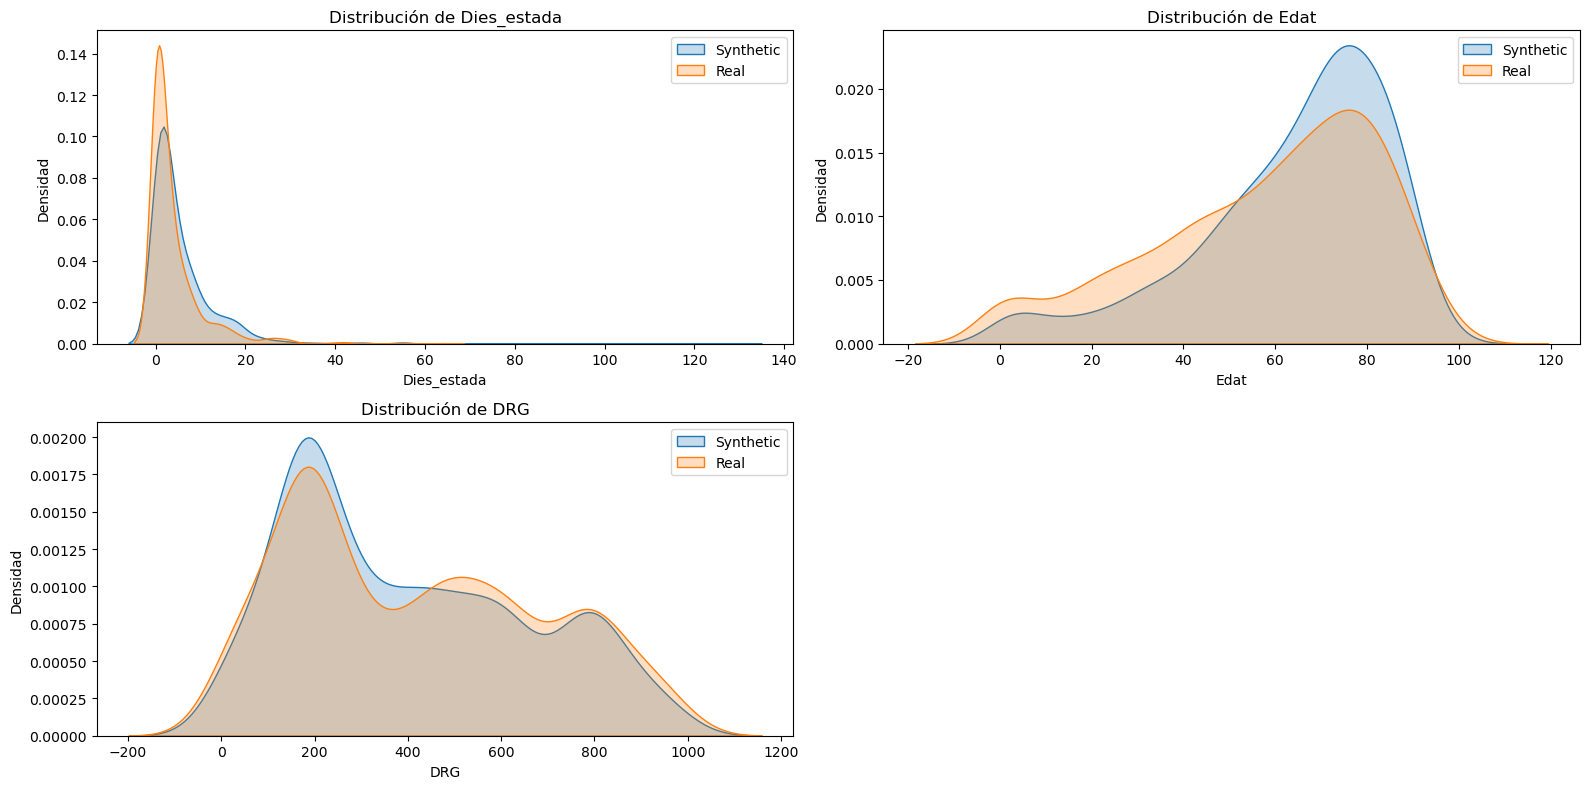

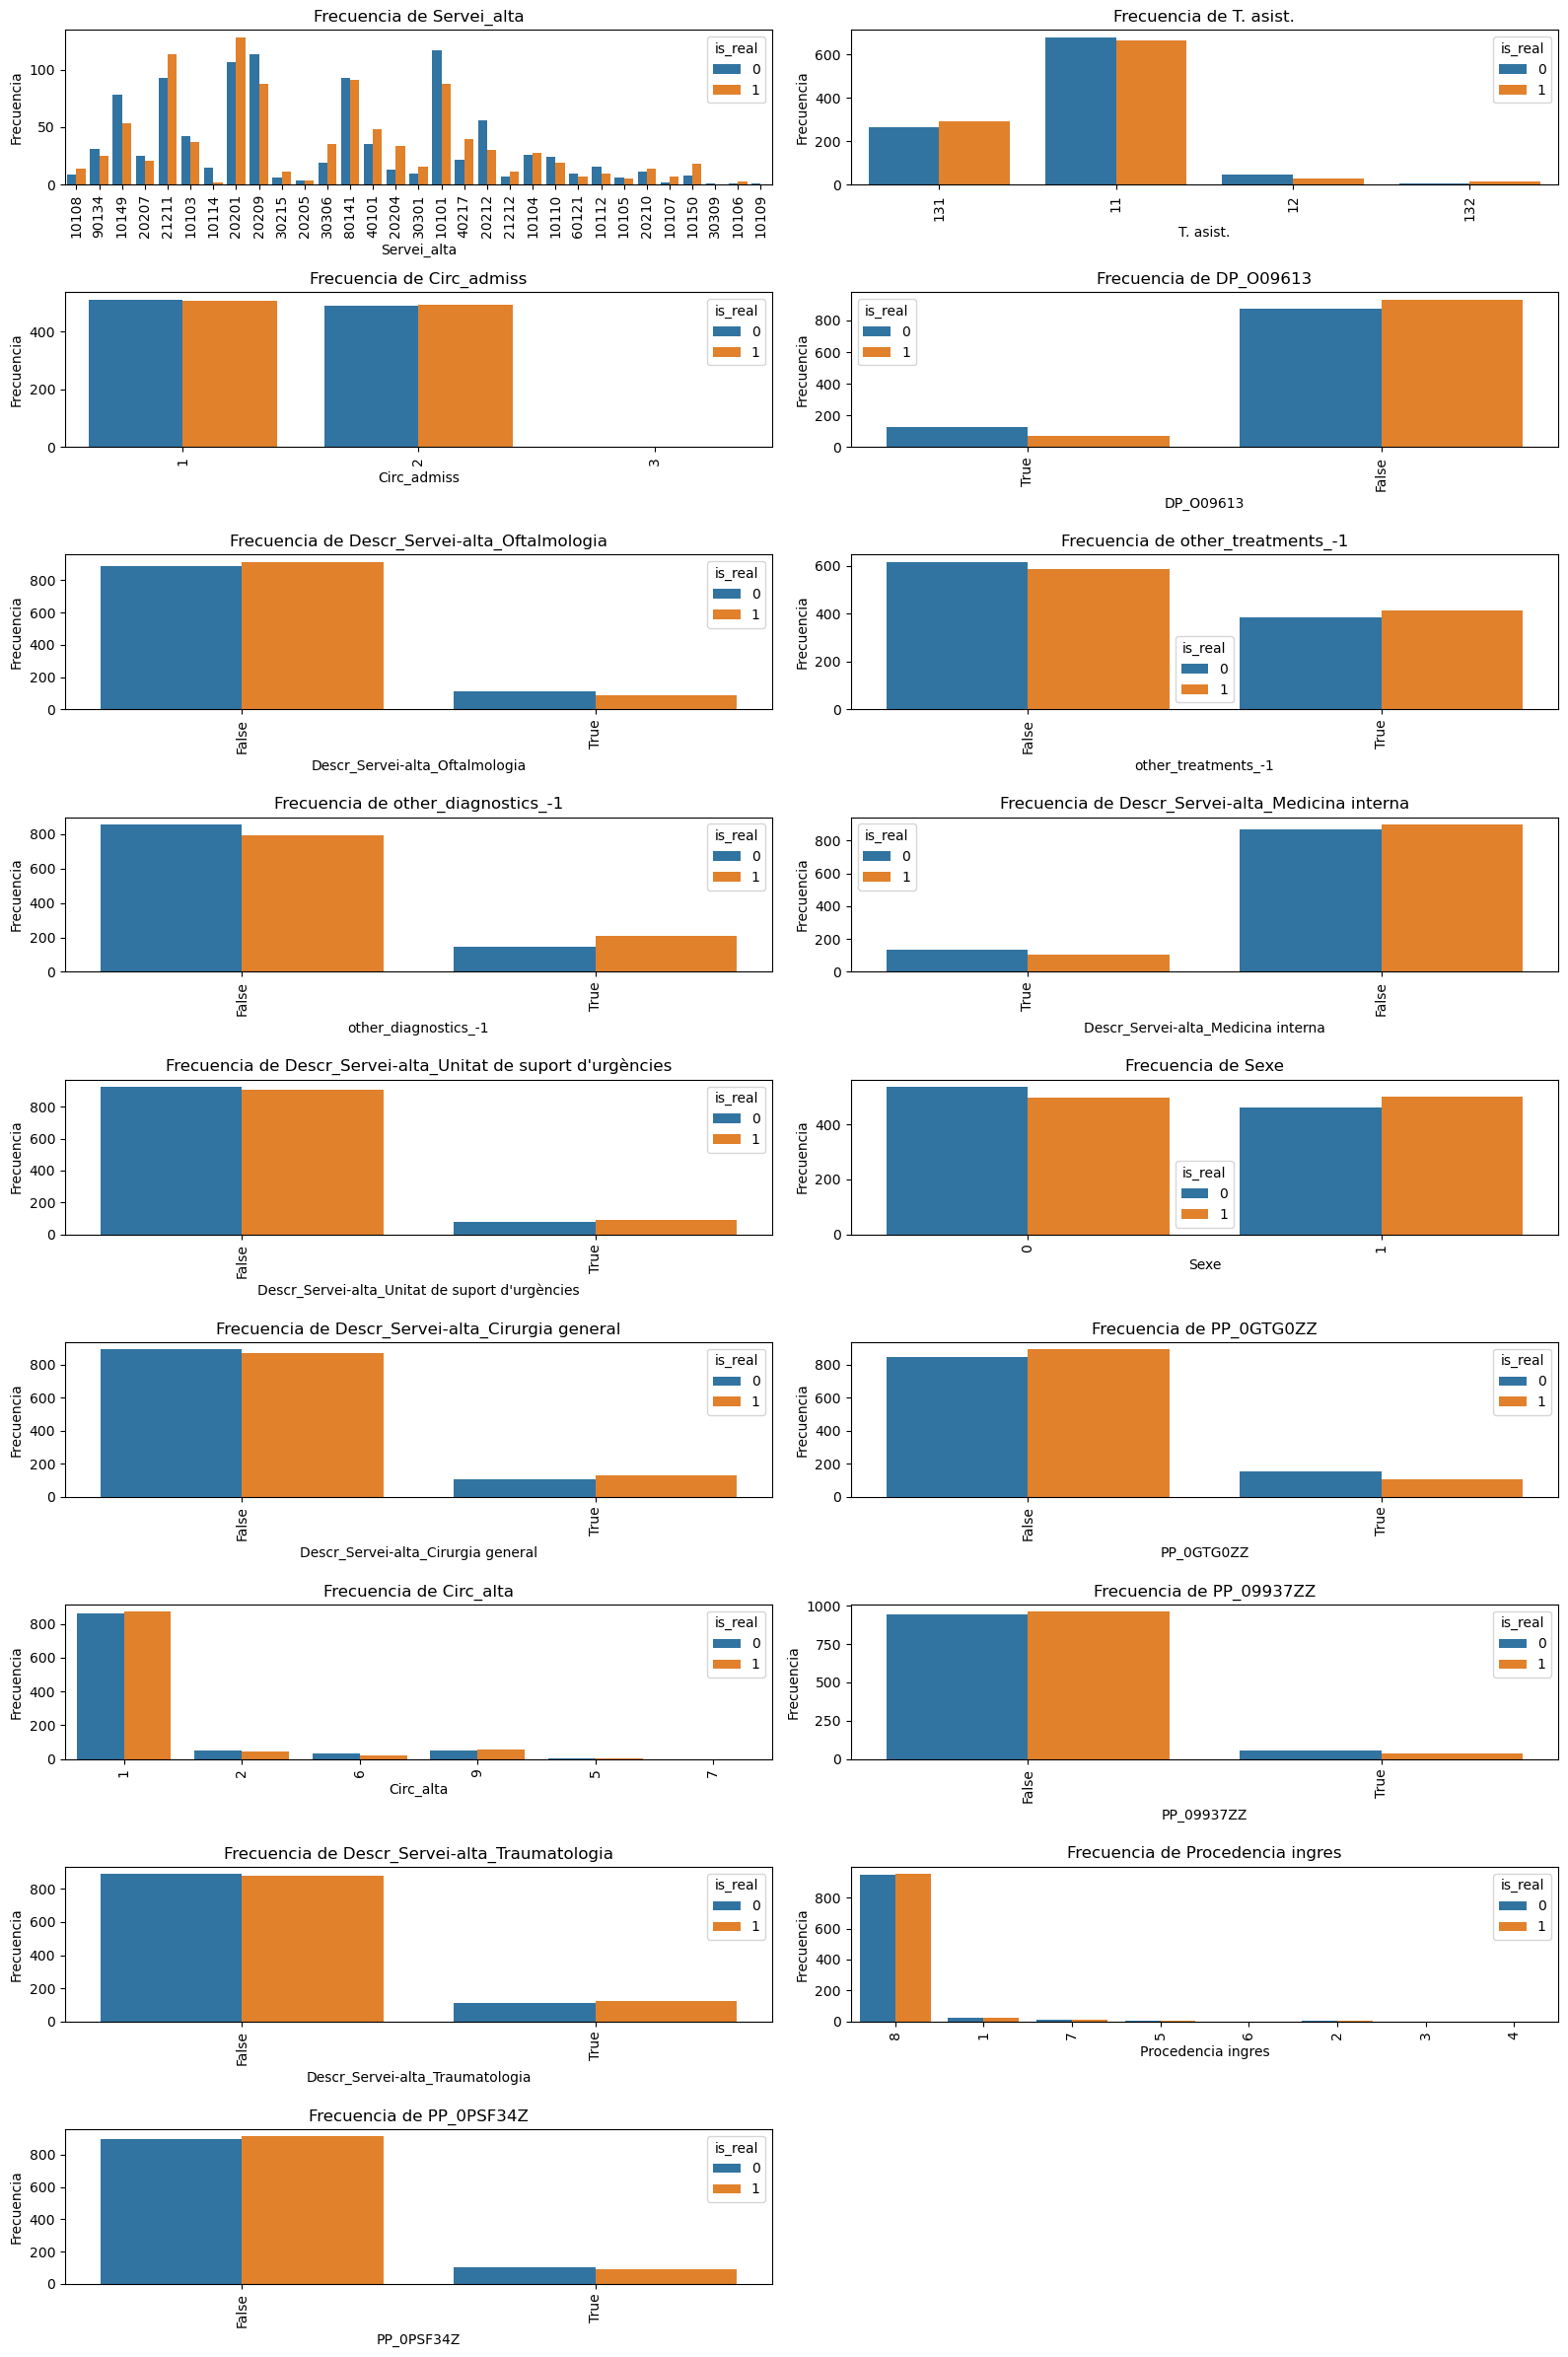

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegurarse de que las variables categóricas sean strings para Seaborn
encoded_data = encoded_data.astype(str)
encoded_data['is_real'] = encoded_data['is_real'].astype(str)

# Obtener la importancia de las características calculadas por RandomForest
# Suponiendo que ya tienes el DataFrame `feature_importance` calculado
# Añadimos 'Edat' si no está presente en el top de importancia
if 'Edat' not in feature_importance['Característica'].values:
    edat_row = pd.DataFrame({'Característica': ['Edat'], 'Importancia': [0]})
    feature_importance = pd.concat([feature_importance, edat_row], ignore_index=True)

# Tomar las 20 características más importantes
top_important_columns = feature_importance.head(20)['Característica'].tolist()

# Identificar automáticamente las variables continuas en 'encoded_data'
continuous_vars = encoded_data.select_dtypes(include=[np.number]).columns.tolist()
continuous_vars = ['Dies_estada', 'Edat', 'DRG']
# Asegurarse de que las variables categóricas sean aquellas que no son numéricas
categorical_vars = [col for col in top_important_columns if col not in continuous_vars]

# Filtrar el conjunto de datos solo con las columnas importantes que existan
filtered_data = encoded_data[[col for col in top_important_columns if col in encoded_data.columns] + ['is_real']]

# Verificar si hay variables continuas antes de graficar
if len(continuous_vars) > 0:
    # Crear subplots para las variables continuas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(continuous_vars) + 1) // 2, ncols=2, figsize=(16, 8))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables continuas
    for i, var in enumerate(continuous_vars):
        if var in filtered_data.columns:
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
            
            axes[i].set_title(f'Distribución de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables continuas para graficar.")

# Verificar si hay variables categóricas antes de graficar
if len(categorical_vars) > 0:
    # Crear subplots para las variables categóricas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(categorical_vars) + 1) // 2, ncols=2, figsize=(16, 24))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables categóricas
    for i, var in enumerate(categorical_vars):
        if var in filtered_data.columns:
            sns.countplot(data=filtered_data, x=var, hue='is_real', ax=axes[i])
            axes[i].set_title(f'Frecuencia de {var}')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frecuencia')

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables categóricas para graficar.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supongamos que tenemos un DataFrame `results_df` con los resultados de cada iteración
# que contiene columnas: 'k', 'n', 'accuracy', 'f1_score' (por ejemplo)
# Aquí seleccionamos la mejor combinación en base a alguna métrica, como el 'f1_score'
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_k = best_iteration['k']
best_n = best_iteration['n']

# Cargar el conjunto de datos correspondiente a la mejor combinación de k y n
best_file_path = f'episodios_sinteticos_k{best_k}_n{best_n}.csv'
synthetic_data = pd.read_csv(best_file_path, sep=';')
real_data = pd.read_csv('data_cluster.csv', sep=';')

# Seleccionar 1000 muestras aleatorias de los datos sintéticos y reales
synthetic_sample = synthetic_data.sample(n=1000, random_state=47).copy()
synthetic_sample['source'] = 'synthetic'

real_sample = real_data.sample(n=1000, random_state=49).copy()
real_sample['source'] = 'real'

# Determinar columnas comunes entre los dos conjuntos de datos
common_columns = synthetic_sample.columns.intersection(real_sample.columns)

# Filtrar ambos conjuntos de datos para que solo contengan columnas comunes
synthetic_sample = synthetic_sample[common_columns]
real_sample = real_sample[common_columns]

# Agrupar las columnas de diagnósticos DS01, DS02... en una sola columna 'other_diagnostics'
diagnosis_columns = [col for col in synthetic_sample.columns if col.startswith('DS')]
synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Agrupar las columnas de tratamientos PS01, PS02... en una sola columna 'other_treatments'
treatment_columns = [col for col in synthetic_sample.columns if col.startswith('PS')]
synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Eliminar las columnas de diagnósticos, tratamientos y POA ya que las hemos agrupado
synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

# Eliminar las columnas de POA (POA1, POA2...) ya que no las queremos considerar
poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

# Combinar los datos sintéticos y reales en un único DataFrame
combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)

# Crear columna objetivo: 1 para datos reales, 0 para sintéticos
combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

# Eliminar columnas innecesarias como 'source' y 'Id_pacient'
combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')

# Eliminar también las columnas de fechas
combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

# Imputar valores faltantes con un valor placeholder (por ejemplo, -1)
combined_data.fillna(-1, inplace=True)

# Convertir variables categóricas a variables dummy
encoded_data = pd.get_dummies(combined_data)

# Definir las características y la variable objetivo
X = encoded_data.drop(columns=['is_real'])
y = encoded_data['is_real']

# Inicializar y entrenar el modelo RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Obtener la importancia de las características
feature_importance = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# --- Plotting the top 20 features ---

# Asegurar que las variables categóricas sean strings para Seaborn
encoded_data = encoded_data.astype(str)
encoded_data['is_real'] = encoded_data['is_real'].astype(str)

# Añadimos 'Edat' si no está en el top de importancia
if 'Edat' not in feature_importance['Característica'].values:
    edat_row = pd.DataFrame({'Característica': ['Edat'], 'Importancia': [0]})
    feature_importance = pd.concat([feature_importance, edat_row], ignore_index=True)

# Tomar las 20 características más importantes
top_important_columns = feature_importance.head(20)['Característica'].tolist()

# Identificar automáticamente las variables continuas en 'encoded_data'
continuous_vars = ['Dies_estada', 'Edat', 'DRG']  # Puedes ajustar esto según tus datos
categorical_vars = [col for col in top_important_columns if col not in continuous_vars]

# Filtrar el conjunto de datos solo con las columnas importantes que existan
filtered_data = encoded_data[[col for col in top_important_columns if col in encoded_data.columns] + ['is_real']]

# Verificar si hay variables continuas antes de graficar
if len(continuous_vars) > 0:
    fig, axes = plt.subplots(nrows=(len(continuous_vars) + 1) // 2, ncols=2, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, var in enumerate(continuous_vars):
        if var in filtered_data.columns:
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
            
            axes[i].set_title(f'Distribución de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Graficar las variables categóricas
if len(categorical_vars) > 0:
    fig, axes = plt.subplots(nrows=(len(categorical_vars) + 1) // 2, ncols=2, figsize=(16, 24))
    axes = axes.flatten()
    
    for i, var in enumerate(categorical_vars):
        if var in filtered_data.columns:
            sns.countplot(data=filtered_data, x=var, hue='is_real', ax=axes[i])
            axes[i].set_title(f'Frecuencia de {var}')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import os
import base64

fake = Faker()

# Funciones auxiliares
def calculate_missing_metrics(df, columns):
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()
    if col_range > 400:
        num_bins = 1000  # Ajustar el número de bins para valores amplios
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()
    return binned_distribution

def generate_base64_id():
    random_bytes = os.urandom(9)
    return base64.b64encode(random_bytes).decode('utf-8').rstrip('=')

def get_value_from_distribution(distribution):
    population = list(distribution.keys())
    weights = list(distribution.values())
    return choices(population, weights, k=1)[0]

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        return diagnoses_with_poa

def assign_diagnoses_or_procedures(distribution, max_assignments):
    assigned_values = choices(list(distribution.keys()), weights=list(distribution.values()), k=max_assignments)
    return assigned_values

def process_diagnosis_for_poa(diagnosis):
    if isinstance(diagnosis, str):
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
    return diagnosis, ""

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    if treatment_type == 'PP':
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        return treatments_secondary

def generate_synthetic_episodes(cluster_id, num_episodes, metrics):
    episodes = []
    for _ in range(num_episodes):
        patient_id = generate_base64_id()
        patient_episodes = get_value_from_distribution(metrics['episode_distribution'])
        for _ in range(patient_episodes):
            edad = randint(20, 80)  # Random age for example
            dies_estada = randint(0, 30)  # Random stay length
            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, 'DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, 'other_diagnoses')
            PS_list = [f'PS{i+1}' for i in range(14)]
            secondary_treatments = assign_treatments_with_missing(metrics, 'other_treatments')
            record = {
                "Id_pacient": patient_id,
                "Edat": edad,
                "Dies_estada": dies_estada,
                "DP": DP,
                "POAP": POAP,
                **{f'DS{i+1}': secondary_diagnoses_with_poa[i][0] for i in range(14)},
                **{f'PS{i+1}': secondary_treatments[i] for i in range(14)},
                "cluster": cluster_id
            }
            episodes.append(record)
    return episodes

# Inicializar variables
n_values = [10, 100, 200]
k_values = [20, 50, 100]
results = []

# Bucle principal sobre k y n
for k in k_values:
    df_cluster = pd.read_csv(f'data_cluster_k{k}.csv', sep=';')
    clusters = df_cluster['cluster'].unique()
    cluster_metrics = {}

    # Procesar por cada cluster
    for cluster in clusters:
        cluster_data = df_cluster[df_cluster['cluster'] == cluster]
        metrics = {'frecuencia_cluster': cluster_data.shape[0] / df_cluster.shape[0]}
        categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta']
        continuous_vars = ['Edat', 'Dies_estada', 'DRG']
        
        for var in categorical_vars:
            metrics[var] = cluster_data[var].value_counts(normalize=True).to_dict()
        for var in continuous_vars:
            metrics[var] = get_custom_binned_distribution(cluster_data, var)
        
        # Bucle por n
        for n in n_values:
            print(f"Procesando k={k}, n={n}, cluster={cluster}")

            # Generar episodios sintéticos
            num_episodes = int(metrics['frecuencia_cluster'] * 60000)
            episodes = generate_synthetic_episodes(cluster, num_episodes, metrics)
            df_episodes = pd.DataFrame(episodes)

            # Entrenar modelo
            real_sample = df_cluster.sample(n=1000, random_state=42)
            df_combined = pd.concat([df_episodes, real_sample])
            df_combined['is_real'] = np.where(df_combined.index < len(df_episodes), 0, 1)

            X = pd.get_dummies(df_combined.drop(columns=['is_real']), dummy_na=True)
            y = df_combined['is_real']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)

            # Evaluar modelo
            y_pred = model.predict(X_test)
            f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
            accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

            results.append({
                'k': k,
                'n': n,
                'f1_score': f1,
                'accuracy': accuracy
            })

            print(f"F1-Score: {f1}, Accuracy: {accuracy}")

# Encontrar el mejor resultado
results_df = pd.DataFrame(results)
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_k = best_iteration['k']
best_n = best_iteration['n']

# Cargar el mejor archivo y graficar
df_best = pd.read_csv(f'episodios_sinteticos_k{best_k}_n{best_n}.csv', sep=';')
encoded_data = pd.get_dummies(df_best.drop(columns=['is_real']), dummy_na=True)

# Plotear las variables más importantes
sns.barplot(x='Importancia', y='Característica', data=feature_importance.head(20))
plt.show()


In [4]:
import pandas as pd
import numpy as np
import os
import base64
from collections import Counter
from datetime import datetime, timedelta
from random import choices, randint
from faker import Faker
import time  # Importar el módulo time para medir tiempos
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

fake = Faker()

# Definición de parámetros
frequency_values = [0.0005, 0.0001]
k_values = [20, 50, 100]
n_values = [10, 100, 200]
results = []

# Funciones auxiliares
def generate_base64_id():
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    population = list(distribution.keys())
    weights = list(distribution.values())
    return choices(population, weights, k=1)[0]

def assign_diagnoses_or_procedures(distribution, max_assignments):
    assigned_values = []
    if 'missing' in distribution:
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            assigned_values = [np.nan] * max_assignments
        else:
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    return assigned_values

def process_diagnosis_for_poa(diagnosis):
    if isinstance(diagnosis, str):
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        return np.nan, np.nan

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            secondary_diagnoses = [np.nan] * 14
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        return diagnoses_with_poa

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    if treatment_type == 'PP':
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            treatments_secondary = [np.nan] * 14
        return treatments_secondary

def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()
    if col_range > 400:
        num_bins = 1000
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()
    return binned_distribution

def calculate_missing_metrics(df, columns):
    df = df.copy()  # Hacer una copia explícita para evitar el SettingWithCopyWarning
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()


def generate_synthetic_episodes(cluster_id, num_episodes, metrics):
    episodes = []
    for _ in range(num_episodes):
        patient_id = generate_base64_id()
        patient_episodes = int(get_value_from_distribution(metrics['episode_distribution']))
        for _ in range(patient_episodes):
            edad_bin = get_value_from_distribution(metrics['Edat'])
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))
            else:
                edad = int(edad_bin)

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            if isinstance(dies_estada_bin, pd.Interval):
                dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            else:
                dies_estada = int(dies_estada_bin)
            dies_estada = max(0, dies_estada)

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            if isinstance(DRG_bin, pd.Interval):
                DRG = randint(int(DRG_bin.left), int(DRG_bin.right))
            else:
                DRG = int(DRG_bin)

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'

            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)

            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id
            }
            episodes.append(record)
    return episodes

# Inicio del bucle principal
for frequency in frequency_values:
    # Cargar y procesar los datos
    df = pd.read_csv('scrambled-CMBDAH 2021-23 episodes.csv', sep=';', low_memory=False)
    df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date
    df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')
    output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
    df.to_csv(output_path_modified,  sep=';', index=False)

    # Modificar diagnósticos y tratamientos
    df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)
    for i in range(1, 15):
        df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

    df['other_diagnostics'] = df[[f'DS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_diagnostics = df.groupby('Id_pacient').agg({
        'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_diagnostics': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()
    diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
    significant_diagnostics = diagnostic_counts[diagnostic_counts > frequency].index

    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

    df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)
    df['other_treatments'] = df[[f'PS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_treatments = df.groupby('Id_pacient').agg({
        'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_treatments': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()
    treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
    significant_treatments = treatment_counts[treatment_counts > frequency].index

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])
    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

    mlb_diagnostics = MultiLabelBinarizer()
    diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
    diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

    mlb_treatments = MultiLabelBinarizer()
    treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
    treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

    df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)
    output_path = 'final_ohe_patients.csv'
    df_combined.to_csv(output_path, sep=';', index=False)

    diagnostics_encoded = diagnostics_df.values
    treatments_encoded = treatments_df.values
    X = np.hstack((diagnostics_encoded, treatments_encoded))

    for k in k_values:
        # Clustering
        import CoreFunctions as cf

        print(f"Combinación actual: frequency = {frequency}, k = {k}")
        print("Muestra de X antes del clustering:")
        print(X[:5])


        M, P, CL = cf.NaiveBayesClustering(X, k)

        if len(CL) == len(df_combined):
            df_combined['cluster'] = CL
        else:
            raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

        df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
        df_cluster.to_csv(f'data_cluster_k{k}.csv', sep=';', index=False)

        clusters = df_cluster['cluster'].unique()
        cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)

        # Aquí iniciamos el bucle sobre n_values
        for n in n_values:
            start_time = time.time()  # Iniciar temporizador
            cluster_metrics = {}

            def get_top_n_diagnoses_with_poa_suffix_v2(df, diagnosis_columns, poa_columns, n, separate_DP=False):
                count_series_secondary = pd.Series(dtype=int)
                count_series_DP = pd.Series(dtype=int)
                missing_count_DP = 0
                missing_count_secondary = 0
                total_count_DP = 0
                total_count_secondary = 0
                poa_suffix_map = {
                    'S': '-S',
                    'N': '-N',
                    'D': '-D',
                    'I': '-I',
                    'E': '-E'
                }
                if separate_DP:
                    df.loc[:, 'DP'] = df.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
                    count_series_DP = df['DP'].value_counts()
                    total_count_DP = len(df['DP'])
                    missing_count_DP = df['DP'].isnull().sum() + (df['DP'] == '').sum()
                    diagnosis_columns = diagnosis_columns[1:]
                    poa_columns = poa_columns[1:]
                for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
                    df.loc[:, diag_col] = df.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
                    missing_count_secondary += df[diag_col].isnull().sum() + (df[diag_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df[diag_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df[diag_col])
                dp_top_n = count_series_DP.nlargest(n)
                dp_top_n_rel = dp_top_n / dp_top_n.sum()
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()
                missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'DP': dp_top_n_rel.to_dict(),
                    'other_diagnoses': secondary_top_n_rel.to_dict(),
                    'missing_DP': missing_proportion_DP,
                    'missing_secondary': calculate_missing_metrics(df, diagnosis_columns)
                }
                return results

            def get_top_n_treatments_with_missing_v2(df, treatment_columns, n, separate_PP=False):
                count_series_secondary = pd.Series(dtype=int)
                count_series_PP = pd.Series(dtype=int)
                missing_count_PP = 0
                missing_count_secondary = 0
                total_count_PP = 0
                total_count_secondary = 0
                if separate_PP:
                    count_series_PP = df['PP'].value_counts()
                    total_count_PP = len(df['PP'])
                    missing_count_PP = df['PP'].isnull().sum() + (df['PP'] == '').sum()
                    treatment_columns = treatment_columns[1:]
                for treatment_col in treatment_columns:
                    missing_count_secondary += df[treatment_col].isnull().sum() + (df[treatment_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df[treatment_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df[treatment_col])
                pp_top_n = count_series_PP.nlargest(n)
                pp_top_n_rel = pp_top_n / pp_top_n.sum()
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()
                missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'PP': pp_top_n_rel.to_dict(),
                    'other_treatments': secondary_top_n_rel.to_dict(),
                    'missing_PP': missing_proportion_PP,
                    'missing_secondary': calculate_missing_metrics(df, treatment_columns)
                }
                return results

            # Cálculo de métricas por cluster con el n actual
            for cluster in clusters:
                cluster_data = df_cluster[df_cluster['cluster'] == cluster]
                metrics = {'frecuencia_cluster': cluster_frequencies[cluster]}
                categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
                continuous_vars = ['Edat', 'Dies_estada', 'DRG']
                episode_counts = cluster_data['Id_pacient'].value_counts()
                metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()
                for var in categorical_vars:
                    metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()
                for var in continuous_vars:
                    metrics[var] = get_custom_binned_distribution(cluster_data, var)
                metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
                    cluster_data,
                    ['DP'] + [f'DS{i}' for i in range(1, 15)],
                    ['POAP'] + [f'POA{i}' for i in range(1, 15)],
                    n=n, separate_DP=True
                )
                metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
                    cluster_data,
                    ['PP'] + [f'PS{i}' for i in range(1, 15)],
                    n=n, separate_PP=True
                )
                cluster_metrics[cluster] = metrics

            # Generación de episodios sintéticos
            total_patients = 60000
            episodes = []
            for cluster_id, metrics in cluster_metrics.items():
                cluster_frequency = metrics['frecuencia_cluster']
                num_episodes = int(cluster_frequency * total_patients)
                episodes += generate_synthetic_episodes(cluster_id, num_episodes, metrics)
            df_episodes = pd.DataFrame(episodes)
            df_episodes.to_csv(f'episodios_sinteticos_k{k}_n{n}_freq{frequency}.csv', sep=';', index=False)

            # Evaluación del modelo
            synthetic_sample = df_episodes.sample(n=1000, random_state=47).copy()
            synthetic_sample['source'] = 'synthetic'
            real_sample = df_cluster.sample(n=1000, random_state=49).copy()
            real_sample['source'] = 'real'
            common_columns = synthetic_sample.columns.intersection(real_sample.columns)
            synthetic_sample = synthetic_sample[common_columns]
            real_sample = real_sample[common_columns]
            synthetic_sample['other_diagnostics'] = synthetic_sample[[f'DS{i}' for i in range(1, 15)]].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_diagnostics'] = real_sample[[f'DS{i}' for i in range(1, 15)]].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            synthetic_sample['other_treatments'] = synthetic_sample[[f'PS{i}' for i in range(1, 15)]].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_treatments'] = real_sample[[f'PS{i}' for i in range(1, 15)]].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            synthetic_sample.drop(columns=[f'DS{i}' for i in range(1, 15)] + [f'PS{i}' for i in range(1, 15)], inplace=True)
            real_sample.drop(columns=[f'DS{i}' for i in range(1, 15)] + [f'PS{i}' for i in range(1, 15)], inplace=True)
            poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
            synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
            real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
            combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)
            combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})
            combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')
            combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')
            combined_data.fillna(-1, inplace=True)
            encoded_data = pd.get_dummies(combined_data)
            X = encoded_data.drop(columns=['is_real'])
            y = encoded_data['is_real']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1_score = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            end_time = time.time()  # Finalizar temporizador
            execution_time = end_time - start_time  # Calcular tiempo de ejecución en segundos
            results.append({
                'frequency': frequency,
                'k': k,
                'n': n,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'execution_time': execution_time  # Almacenar tiempo de ejecución
            })

# Encontrar el mejor resultado
results_df = pd.DataFrame(results)
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_frequency = best_iteration['frequency']
best_k = best_iteration['k']
best_n = best_iteration['n']

print("Mejores parámetros encontrados:")
print(f"Frequency: {best_frequency}, k: {best_k}, n: {best_n}")
print(f"F1-Score: {best_iteration['f1_score']}, Precision: {best_iteration['precision']}, Recall: {best_iteration['recall']}")
print(f"Tiempo de ejecución: {best_iteration['execution_time']} segundos")

# Mostrar el DataFrame de resultados con tiempos de ejecución
print("\nResultados completos:")
print(results_df)

# Cargar el mejor archivo y graficar (opcional)
# df_best = pd.read_csv(f'episodios_sinteticos_k{best_k}_n{best_n}_freq{best_frequency}.csv', sep=';')



Combinación actual: frequency = 0.0005, k = 20
Muestra de X antes del clustering:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Combinación actual: frequency = 0.0005, k = 50
Muestra de X antes del clustering:
   Edat  Sexe  Circ_admiss  Procedencia ingres  Circ_alta  Dies_estada  \
0    47     0            1                   8          1            0   
1    72     0            2                   1          2            0   
2    30     0            2                   8          1            1   
3    31     1            1                   8          1            2   
4    49     0            1                   8          1            2   

   Servei_alta  DRG  T. asist.  Descr_Servei-alta_Altres serveis mèdics  ...  \
0        20201  756         11                                    False  ...   
1        20207  322         11                                    False  ...   
2        10101  891        131                         

UFuncTypeError: Cannot cast ufunc 'svd_n_f' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [6]:
import pandas as pd
import numpy as np
import os
import base64
from collections import Counter
from datetime import datetime, timedelta
from random import choices, randint
from faker import Faker
import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

fake = Faker()

# Definición de parámetros
frequency_values = [0.0005, 0.0001]
k_values = [20, 50, 100]
n_values = [10, 100, 200]
results = []

# Funciones auxiliares
def generate_base64_id():
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    population = list(distribution.keys())
    weights = list(distribution.values())
    return choices(population, weights, k=1)[0]

def assign_diagnoses_or_procedures(distribution, max_assignments):
    assigned_values = []
    if 'missing' in distribution:
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            assigned_values = [np.nan] * max_assignments
        else:
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    return assigned_values

def process_diagnosis_for_poa(diagnosis):
    if isinstance(diagnosis, str):
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        return np.nan, np.nan

def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    if diagnosis_type == 'DP':
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            secondary_diagnoses = [np.nan] * 14
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        return diagnoses_with_poa

def assign_treatments_with_missing(metrics, treatment_type='PP'):
    if treatment_type == 'PP':
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        if np.random.rand() < missing_secondary_probability:
            treatments_secondary = [np.nan] * 14
        return treatments_secondary

def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()
    if col_range > 400:
        num_bins = 1000
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()
    return binned_distribution

def calculate_missing_metrics(df, columns):
    df = df.copy()  # Evitar SettingWithCopyWarning
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

def generate_synthetic_episodes(cluster_id, num_episodes, metrics):
    episodes = []
    for _ in range(num_episodes):
        patient_id = generate_base64_id()
        patient_episodes = int(get_value_from_distribution(metrics['episode_distribution']))
        for _ in range(patient_episodes):
            edad_bin = get_value_from_distribution(metrics['Edat'])
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))
            else:
                edad = int(edad_bin)

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            if isinstance(dies_estada_bin, pd.Interval):
                dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            else:
                dies_estada = int(dies_estada_bin)
            dies_estada = max(0, dies_estada)

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            if isinstance(DRG_bin, pd.Interval):
                DRG = randint(int(DRG_bin.left), int(DRG_bin.right))
            else:
                DRG = int(DRG_bin)

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'

            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)

            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id
            }
            episodes.append(record)
    return episodes

# Inicio del bucle principal
for frequency in frequency_values:
    # Cargar y procesar los datos
    df = pd.read_csv('scrambled-CMBDAH 2021-23 episodes.csv', sep=';', low_memory=False)
    df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date
    df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')
    output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
    df.to_csv(output_path_modified,  sep=';', index=False)

    # Modificar diagnósticos y tratamientos
    df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)
    for i in range(1, 15):
        df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

    df['other_diagnostics'] = df[[f'DS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_diagnostics = df.groupby('Id_pacient').agg({
        'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_diagnostics': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()
    diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
    significant_diagnostics = diagnostic_counts[diagnostic_counts > frequency].index

    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

    df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)
    df['other_treatments'] = df[[f'PS{i}' for i in range(1, 15)]].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)
    df_grouped_treatments = df.groupby('Id_pacient').agg({
        'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,
        'other_treatments': lambda x: [item for sublist in x for item in sublist]
    }).reset_index()

    all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()
    treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
    significant_treatments = treatment_counts[treatment_counts > frequency].index

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])
    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

    # Asegurarse de que no hay valores None o listas vacías
    df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if x else ['Unknown'])

    df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x else ['Unknown'])
    df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if x else ['Unknown'])

    # Aplicar MultiLabelBinarizer
    mlb_diagnostics = MultiLabelBinarizer()
    diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
    diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

    mlb_treatments = MultiLabelBinarizer()
    treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
    treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

    df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)
    output_path = 'final_ohe_patients.csv'
    df_combined.to_csv(output_path, sep=';', index=False)

    diagnostics_encoded = diagnostics_df.values.astype(np.float64)
    treatments_encoded = treatments_df.values.astype(np.float64)
    X_clustering = np.hstack((diagnostics_encoded, treatments_encoded))

    for k in k_values:
        # Clustering
        import CoreFunctions as cf

        print(f"Combinación actual: frequency = {frequency}, k = {k}")
        print("Muestra de X_clustering antes del clustering:")
        print(X_clustering[:5])
        print(f"Tipo de datos de X_clustering: {X_clustering.dtype}")

        if X_clustering.dtype == 'O':
            X_clustering = X_clustering.astype(np.float64)
            print("Se ha convertido X_clustering a tipo float64.")

        M, P, CL = cf.NaiveBayesClustering(X_clustering, k)

        if len(CL) == len(df_combined):
            df_combined['cluster'] = CL
        else:
            raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

        df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
        df_cluster.to_csv(f'data_cluster_k{k}.csv', sep=';', index=False)

        clusters = df_cluster['cluster'].unique()
        cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)

        # Aquí iniciamos el bucle sobre n_values
        for n in n_values:
            start_time = time.time()
            cluster_metrics = {}

            def get_top_n_diagnoses_with_poa_suffix_v2(df_subset, diagnosis_columns, poa_columns, n, separate_DP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_DP = pd.Series(dtype=int)
                missing_count_DP = 0
                missing_count_secondary = 0
                total_count_DP = 0
                total_count_secondary = 0
                poa_suffix_map = {
                    'S': '-S',
                    'N': '-N',
                    'D': '-D',
                    'I': '-I',
                    'E': '-E'
                }
                if separate_DP:
                    df_subset.loc[:, 'DP'] = df_subset.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
                    count_series_DP = df_subset['DP'].value_counts()
                    total_count_DP = len(df_subset['DP'])
                    missing_count_DP = df_subset['DP'].isnull().sum() + (df_subset['DP'] == '').sum()
                    diagnosis_columns = diagnosis_columns[1:]
                    poa_columns = poa_columns[1:]
                for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
                    df_subset.loc[:, diag_col] = df_subset.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
                    missing_count_secondary += df_subset[diag_col].isnull().sum() + (df_subset[diag_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[diag_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[diag_col])
                dp_top_n = count_series_DP.nlargest(n)
                dp_top_n_rel = dp_top_n / dp_top_n.sum() if dp_top_n.sum() > 0 else dp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'DP': dp_top_n_rel.to_dict(),
                    'other_diagnoses': secondary_top_n_rel.to_dict(),
                    'missing_DP': missing_proportion_DP,
                    'missing_secondary': calculate_missing_metrics(df_subset, diagnosis_columns)
                }
                return results

            def get_top_n_treatments_with_missing_v2(df_subset, treatment_columns, n, separate_PP=False):
                df_subset = df_subset.copy()
                count_series_secondary = pd.Series(dtype=int)
                count_series_PP = pd.Series(dtype=int)
                missing_count_PP = 0
                missing_count_secondary = 0
                total_count_PP = 0
                total_count_secondary = 0
                if separate_PP:
                    count_series_PP = df_subset['PP'].value_counts()
                    total_count_PP = len(df_subset['PP'])
                    missing_count_PP = df_subset['PP'].isnull().sum() + (df_subset['PP'] == '').sum()
                    treatment_columns = treatment_columns[1:]
                for treatment_col in treatment_columns:
                    missing_count_secondary += df_subset[treatment_col].isnull().sum() + (df_subset[treatment_col] == '').sum()
                    count_series_secondary = count_series_secondary.add(df_subset[treatment_col].value_counts(), fill_value=0)
                    total_count_secondary += len(df_subset[treatment_col])
                pp_top_n = count_series_PP.nlargest(n)
                pp_top_n_rel = pp_top_n / pp_top_n.sum() if pp_top_n.sum() > 0 else pp_top_n
                secondary_top_n = count_series_secondary.nlargest(n)
                secondary_top_n_rel = secondary_top_n / secondary_top_n.sum() if secondary_top_n.sum() > 0 else secondary_top_n
                missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
                missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0
                results = {
                    'PP': pp_top_n_rel.to_dict(),
                    'other_treatments': secondary_top_n_rel.to_dict(),
                    'missing_PP': missing_proportion_PP,
                    'missing_secondary': calculate_missing_metrics(df_subset, treatment_columns)
                }
                return results

            # Cálculo de métricas por cluster con el n actual
            for cluster_id in clusters:
                cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
                metrics = {'frecuencia_cluster': cluster_frequencies[cluster_id]}
                categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
                continuous_vars = ['Edat', 'Dies_estada', 'DRG']
                episode_counts = cluster_data['Id_pacient'].value_counts()
                metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()
                for var in categorical_vars:
                    metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()
                for var in continuous_vars:
                    metrics[var] = get_custom_binned_distribution(cluster_data, var)
                metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
                    cluster_data,
                    ['DP'] + [f'DS{i}' for i in range(1, 15)],
                    ['POAP'] + [f'POA{i}' for i in range(1, 15)],
                    n=n, separate_DP=True
                )
                metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
                    cluster_data,
                    ['PP'] + [f'PS{i}' for i in range(1, 15)],
                    n=n, separate_PP=True
                )
                cluster_metrics[cluster_id] = metrics

            # Generación de episodios sintéticos
            total_patients = 60000
            episodes = []
            for cluster_id, metrics in cluster_metrics.items():
                cluster_frequency = metrics['frecuencia_cluster']
                num_episodes = int(cluster_frequency * total_patients)
                episodes += generate_synthetic_episodes(cluster_id, num_episodes, metrics)
            df_episodes = pd.DataFrame(episodes)
            df_episodes.to_csv(f'episodios_sinteticos_k{k}_n{n}_freq{frequency}.csv', sep=';', index=False)

            # Evaluación del modelo
            synthetic_sample = df_episodes.sample(n=1000, random_state=47).copy()
            synthetic_sample['source'] = 'synthetic'
            real_sample = df_cluster.sample(n=1000, random_state=49).copy()
            real_sample['source'] = 'real'

            # Preparar los datos para el modelo RandomForest
            common_columns = synthetic_sample.columns.intersection(real_sample.columns)
            synthetic_sample = synthetic_sample[common_columns]
            real_sample = real_sample[common_columns]

            diagnosis_columns = [f'DS{i}' for i in range(1, 15)]
            treatment_columns = [f'PS{i}' for i in range(1, 15)]

            synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
            real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

            synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
            real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

            poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
            synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
            real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

            combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)
            combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

            combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')
            combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

            combined_data.fillna(-1, inplace=True)

            encoded_data = pd.get_dummies(combined_data)

            # Usamos 'X_eval' y 'y_eval' para evitar sobrescribir 'X'
            X_eval = encoded_data.drop(columns=['is_real'])
            y_eval = encoded_data['is_real']

            X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)
            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1_score = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            end_time = time.time()
            execution_time = end_time - start_time
            results.append({
                'frequency': frequency,
                'k': k,
                'n': n,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'execution_time': execution_time
            })

# Encontrar el mejor resultado
results_df = pd.DataFrame(results)
best_iteration = results_df.loc[results_df['f1_score'].idxmax()]
best_frequency = best_iteration['frequency']
best_k = best_iteration['k']
best_n = best_iteration['n']

print("Mejores parámetros encontrados:")
print(f"Frequency: {best_frequency}, k: {best_k}, n: {best_n}")
print(f"F1-Score: {best_iteration['f1_score']}, Precision: {best_iteration['precision']}, Recall: {best_iteration['recall']}")
print(f"Tiempo de ejecución: {best_iteration['execution_time']} segundos")

# Mostrar el DataFrame de resultados con tiempos de ejecución
print("\nResultados completos:")
print(results_df)

# Cargar el mejor archivo y graficar (opcional)
# df_best = pd.read_csv(f'episodios_sinteticos_k{best_k}_n{best_n}_freq{best_frequency}.csv', sep=';')


Combinación actual: frequency = 0.0005, k = 20
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0005, k = 50
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0005, k = 100
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo de datos de X_clustering: float64
Combinación actual: frequency = 0.0001, k = 20
Muestra de X_clustering antes del clustering:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Tipo d